In [1]:
import sys
import os

import librosa  # python package for music and audio analysis
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

import noisereduce as no
import matplotlib.image as mpimg
import tensorflow as tf

from pprint import pprint 
import imutils
import cv2
import random

import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

/opt/anaconda3/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.head(10)

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
5,4.0,no,aldfly,2 (stereo),2013-05-27,Not specified,7,XC135459.mp3,Not specified,Alder Flycatcher,...,135459,https://www.xeno-canto.org/135459,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,Not specified,08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
6,4.0,no,aldfly,2 (stereo),2013-05-27,Not specified,45,XC135460.mp3,Not specified,Alder Flycatcher,...,135460,https://www.xeno-canto.org/135460,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,Not specified,10:00,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
7,3.5,no,aldfly,2 (stereo),2013-05-30,increasing,71,XC135883.mp3,level,Alder Flycatcher,...,135883,https://www.xeno-canto.org/135883,United States,Guy McGrane,Empidonax alnorum_Alder Flycatcher,-81.4814,0-3(s),10:30,Guy McGrane,Creative Commons Attribution-NonCommercial-Sha...
8,4.0,no,aldfly,2 (stereo),2013-06-02,both,26,XC137570.mp3,accelerating,Alder Flycatcher,...,137570,https://www.xeno-canto.org/137570,Canada,Martin St-Michel,Empidonax alnorum_Alder Flycatcher,-70.42,0-3(s),07:03,Martin St-Michel,Creative Commons Attribution-NonCommercial-Sha...
9,3.5,no,aldfly,1 (mono),2013-06-16,Not specified,54,XC138639.mp3,Not specified,Alder Flycatcher,...,138639,https://www.xeno-canto.org/138639,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-91.4698,Not specified,06:24,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0


In [4]:
fmin = 300
# References:
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# https://github.com/m-kortas/Sound-based-bird-species-detection/blob/master/MK_prepareData.ipynb
def get_melspectrogram_db(file_path):
    n_fft = 2048
    hop_length = 512   
    n_mels = 256

    signal, sr = librosa.load(file_path, duration=30*60)

#     signal_limit = sr*sec_limit
#     if signal.shape[0] > signal_limit:
#         signal = signal[:signal_limit]
    
    signal = no.reduce_noise(audio_clip=signal, noise_clip=signal, verbose=False)

    spec = librosa.feature.melspectrogram(
        signal, 
        sr=sr, 
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin
    )
    
    return librosa.power_to_db(spec, ref=np.max)

In [5]:
# References:
# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    spec_scaled = np.flip(spec_scaled, axis=0)

    return spec_scaled

In [6]:
def sample_imgs(img):
    target_sample_size = 6
    blank_threshold = 0.9
    population = img.shape[1]
    sample_size = random.randrange(220, 251, 1)
    split_num = int(np.ceil(population/sample_size))
    imgs = np.array_split(img, split_num, axis=1)
    imgs = list(filter(lambda x: sum(x.flatten() == 0)/len(x.flatten()) < blank_threshold, imgs))
    
    if len(imgs) > target_sample_size:
        imgs = random.sample(imgs, target_sample_size)
    
    return imgs

In [7]:
def resize_img(img, size=256):    
    height, width = img.shape
    padding = int(np.floor(np.abs(
        (width - height)/2
    )))
    dimension = width if width > height else height 

    img_padded = np.zeros((dimension, dimension))
    
    if height < width:
        img_padded[padding:(padding + height), :width] = img
    else: 
        img_padded[:height, padding:(padding + width)] = img

    return imutils.resize(img_padded, width=size)

In [9]:
def file_to_imgs(file, bird_storage_dir, existing_file_labels):
    if file.endswith(".mp3"):
        file_label = file.split('/')[-1].split('.')[0]

        if file_label in existing_file_labels[bird]:
            return

        file_name = file_label + '.png'

        img = spec_to_image(get_melspectrogram_db(file))
        imgs = sample_imgs(img)

        for i, img in enumerate(imgs):            
            img = resize_img(img)
            mpimg.imsave(bird_storage_dir + "/" + str(i + 1) + '-' + file_name, img, cmap='gray')

In [10]:
# Example
train.iloc[7]

rating                                                            3.5
playback_used                                                      no
ebird_code                                                     aldfly
channels                                                   2 (stereo)
date                                                       2013-05-30
pitch                                                      increasing
duration                                                           71
filename                                                 XC135883.mp3
speed                                                           level
species                                              Alder Flycatcher
number_of_notes                                                   1-3
title                   XC135883 Alder Flycatcher (Empidonax alnorum)
secondary_labels    ['Geothlypis trichas_Common Yellowthroat', 'Du...
bird_seen                                                         yes
sci_name            

In [11]:
example_file = './data/train_audio/aldfly/XC135883.mp3'

In [12]:
mel = get_melspectrogram_db(example_file)
img = spec_to_image(mel)

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [13]:
img.shape

(256, 3068)

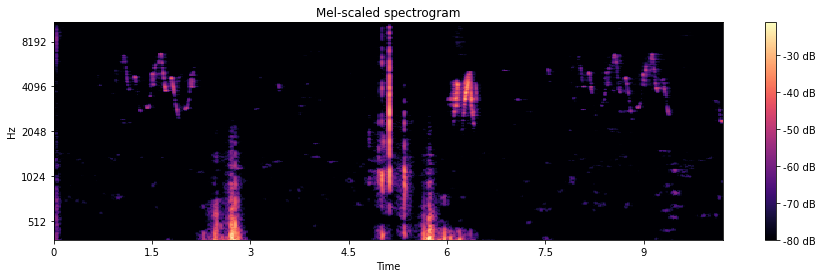

In [14]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(mel[:, :440], fmin=fmin, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-scaled spectrogram')
plt.show()

In [15]:
img_resized = resize_img(sample_imgs(img)[0])

In [16]:
img_resized.shape

(256, 256)

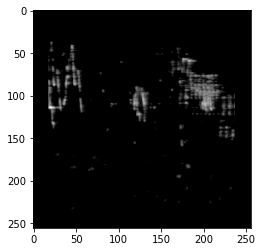

In [17]:
plt.imshow(img_resized, cmap='gray')

In [18]:
mpimg.imsave("example.png", img_resized, cmap='gray')

In [19]:
working_dir = "./data/train_audio/"
birds = []
flist = {} 

for root, dirs, files in os.walk(working_dir):
    if root == working_dir:
        birds = dirs

for i, bird in enumerate(birds):
    blist = [] 
    
    for root, dirs, files in os.walk(working_dir + bird):
        for file in files:
            if file.endswith(".mp3"):
                blist.append(os.path.join(root, file))

    flist[bird] = blist

In [20]:
storage_dir = "./data/train_img/"
existing_file_labels = {}

for i, bird in enumerate(birds):
    blist = [] 
    
    for root, dirs, files in os.walk(storage_dir + bird):
        for file in files:
            if file.endswith(".png"):
                blist.append(file.split('-')[1].split('.')[0])

    existing_file_labels[bird] = blist

In [28]:
num_cores = multiprocessing.cpu_count()

In [31]:
def my_function(num):
    return num*2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

birds_handled = 0

for bird, files in flist.items():
    bird_dir = storage_dir + bird
    
    if not os.path.exists(bird_dir):
        os.mkdir(bird_dir)
    
    birds_handled += 1
    print(birds_handled)

    Parallel(n_jobs=num_cores)(
        delayed(file_to_imgs)(file, storage_dir + bird, existing_file_labels) for file in files
    )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
